In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter

import plotly.graph_objects as go
import plotly.express as px

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import scipy

import inference
import learning
import torch

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

In [2]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [3]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")

In [4]:
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

In [5]:
subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

# Choose Valid Sessions

In [6]:
sessions_ = sessions.iloc[[4,8,10,11,14,16,17,20,23,24,25,26,28,29,30,31]]

In [7]:
short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]

In [8]:
long_sessions = sessions.iloc[[8, 10, 11, 14]]

# Filter Each Session

In [15]:
def LDSParameters_Manual(dt):
    pos_x0, pos_y0 = 0, 0
    vel_x0, vel_y0 = 0.0, 0.0
    acc_x0, acc_y0 = 0.0, 0.0

    # Manual Parameters
    sigma_a = 0.5
    sqrt_diag_V0_value = 1e-3

    m0 = np.array([pos_x0, vel_x0, acc_x0, pos_y0, vel_y0, acc_y0], dtype=np.double)
    V0 = np.diag(np.ones(len(m0))*sqrt_diag_V0_value**2)


    B = np.array([[1, dt, dt**2/2, 0, 0, 0],
                [0, 1, dt, 0, 0, 0],
                [0, 0, 1, 0, 0, 0],
                [0, 0, 0, 1, dt, dt**2/2],
                [0, 0, 0, 0, 1, dt],
                [0, 0, 0, 0, 0, 1]],
                dtype=np.double)


    Qe = np.array([[dt**5/20, dt**4/8, dt**3/6, 0, 0, 0],
                [dt**4/8, dt**3/3,  dt**2/2, 0, 0, 0],
                [dt**3/6, dt**2/2,  dt,      0, 0, 0],
                [0, 0, 0,                    dt**5/20, dt**4/8, dt**3/6],
                [0, 0, 0,                    dt**4/8, dt**3/3,  dt**2/2],
                [0, 0, 0,                    dt**3/6, dt**2/2,  dt]],
                dtype=np.double)
    Q = sigma_a**2 * Qe

    sigma_x = 1
    sigma_y = 1

    Z = np.array([[1, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 0]],
                dtype=np.double)
    R = np.diag([sigma_x**2, sigma_y**2])
    
    return sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R

In [16]:
def LDSParameters_Learned(y, dt, sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R):
    pos_x0, pos_y0 = y[0,0], y[1,0]
    vel_x0, vel_y0 = 0.0, 0.0
    acc_x0, acc_y0 = 0.0, 0.0
    
    # Learning Parameters
    lbfgs_max_iter = 2
    lbfgs_tolerance_grad = -1
    lbfgs_tolerance_change = 1e-3
    lbfgs_lr = 0.01
    lbfgs_n_epochs = 75
    lbfgs_tol = 1e-3
    Qe_reg_param_learned = 1e-2
    sqrt_diag_R_torch = torch.DoubleTensor([sigma_x, sigma_y])
    m0_torch = torch.from_numpy(m0.copy())
    sqrt_diag_V0_torch = torch.DoubleTensor([sqrt_diag_V0_value
                                            for i in range(len(m0))])
    if Qe_reg_param_learned is not None:
        Qe_regularized_learned = Qe + Qe_reg_param_learned * np.eye(Qe.shape[0])
    else:
        Qe_regularized_learned = Qe
    y_torch = torch.from_numpy(y.astype(np.double))
    B_torch = torch.from_numpy(B.astype(np.double))
    Qe_regularized_learned_torch = torch.from_numpy(Qe_regularized_learned.astype(np.double))
    Z_torch = torch.from_numpy(Z.astype(np.double))

    vars_to_estimate = {}
    vars_to_estimate["sigma_a"] = True
    vars_to_estimate["sqrt_diag_R"] = True
    vars_to_estimate["R"] = True
    vars_to_estimate["m0"] = True
    vars_to_estimate["sqrt_diag_V0"] = True
    vars_to_estimate["V0"] = True

    optim_res_learned = learning.torch_lbfgs_optimize_SS_tracking_diagV0(
        y=y_torch, B=B_torch, sigma_a0=sigma_a,
        Qe=Qe_regularized_learned_torch, Z=Z_torch, sqrt_diag_R_0=sqrt_diag_R_torch, m0_0=m0_torch,
        sqrt_diag_V0_0=sqrt_diag_V0_torch, max_iter=lbfgs_max_iter, lr=lbfgs_lr,
        vars_to_estimate=vars_to_estimate, tolerance_grad=lbfgs_tolerance_grad,
        tolerance_change=lbfgs_tolerance_change, n_epochs=lbfgs_n_epochs,
        tol=lbfgs_tol)
    
    sigma_a = optim_res_learned["estimates"]["sigma_a"].item()
    sigma_x = optim_res_learned["estimates"]["sqrt_diag_R"].numpy()[0]
    sigma_y = optim_res_learned["estimates"]["sqrt_diag_R"].numpy()[1]
    sqrt_diag_V0_value = optim_res_learned["estimates"]["sqrt_diag_V0"].numpy()
    Q = sigma_a**2*Qe
    m0 = optim_res_learned["estimates"]["m0"].numpy()
    V0 = np.diag(sqrt_diag_V0_value**2)
    R = np.diag(optim_res_learned["estimates"]["sqrt_diag_R"].numpy()**2)

    return sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Q, m0, V0, Z, R

## Short Sessions

BAA-1100700


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


BAA-1101818


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


BAA-1101819


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


BAA-1101818


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


BAA-1101818
BAA-1101823
BAA-1101821


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


BAA-1101819


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


BAA-1101818


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


BAA-1101819
BAA-1101818
BAA-1101819


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]
/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: invalid value encountered in subtract
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


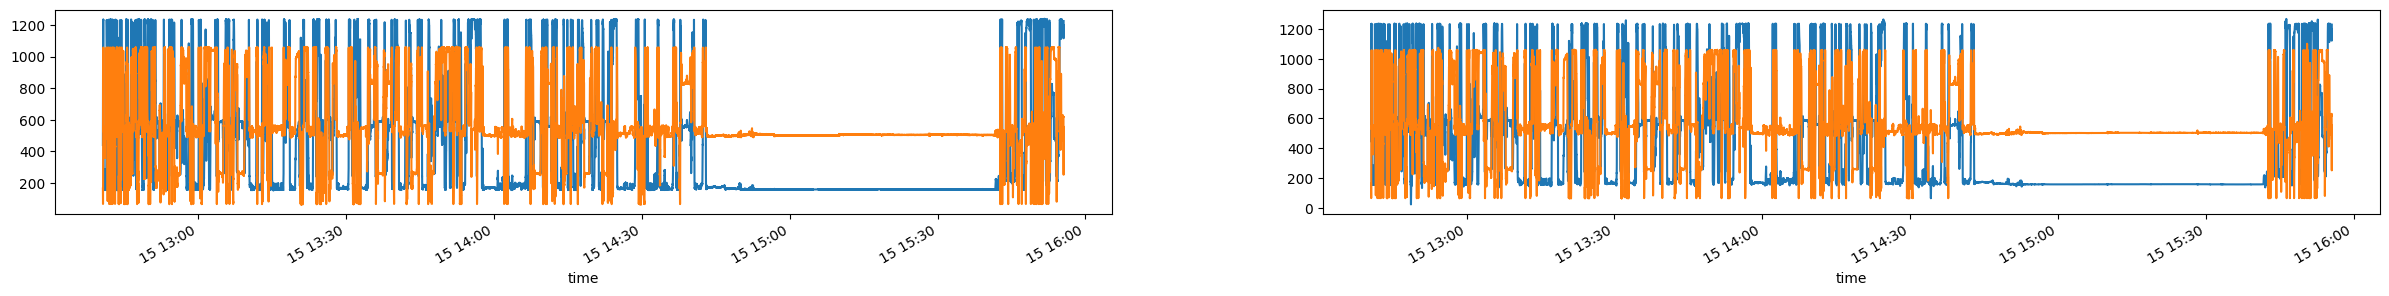

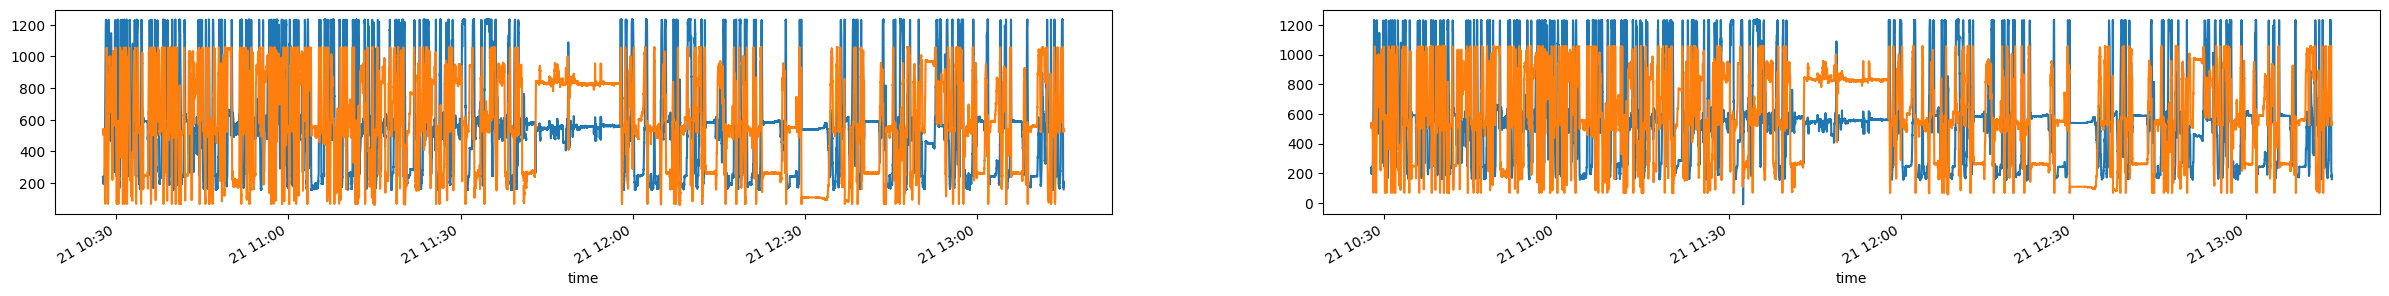

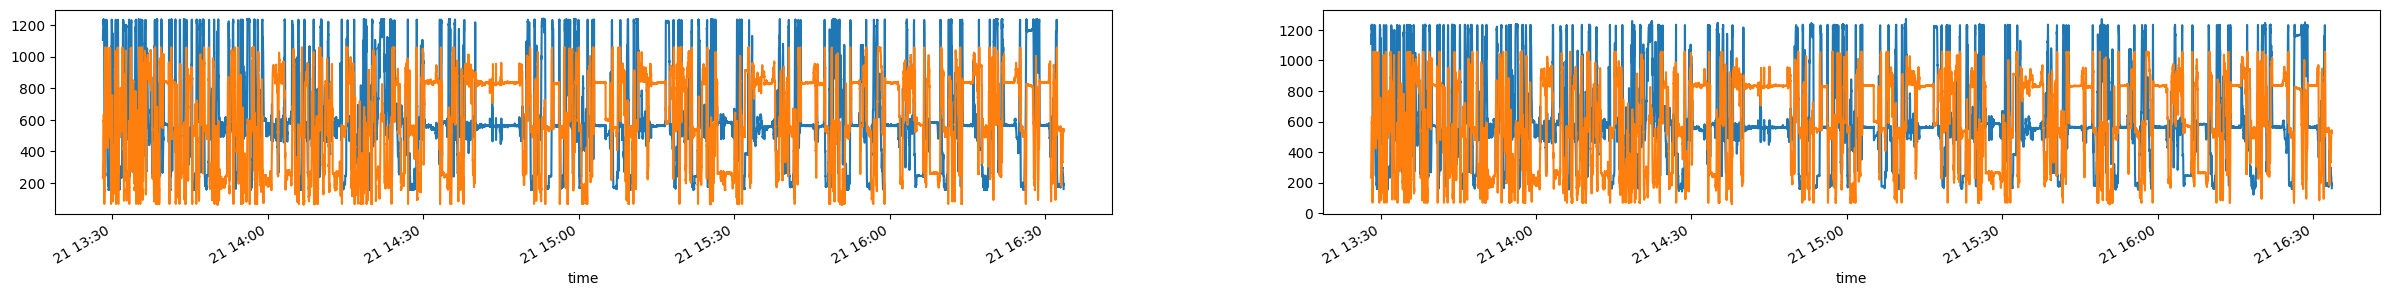

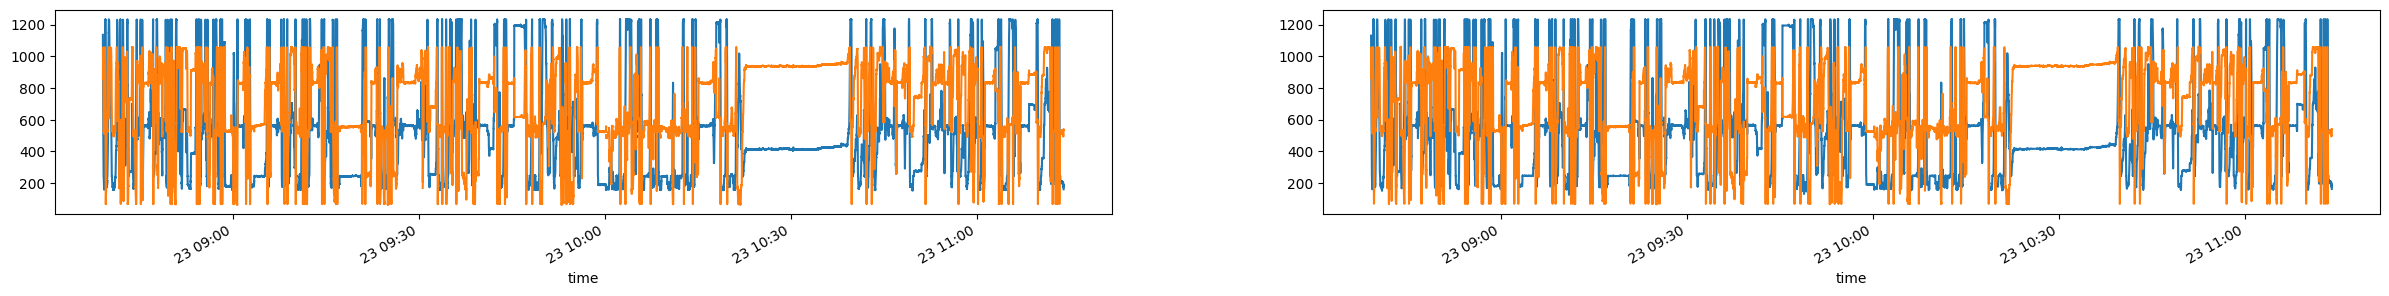

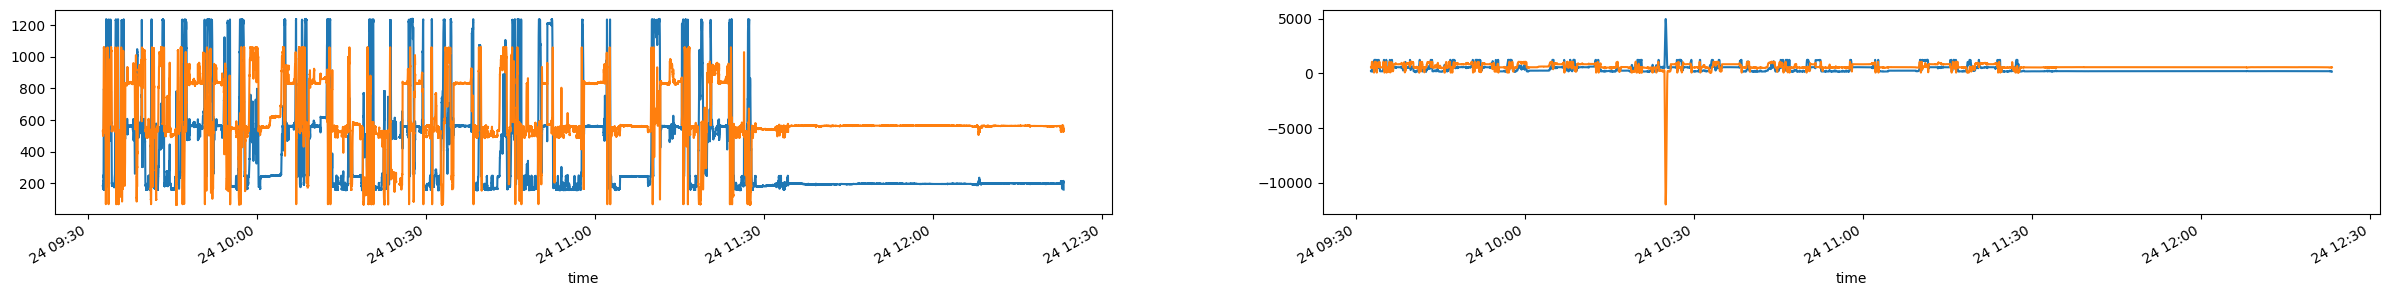

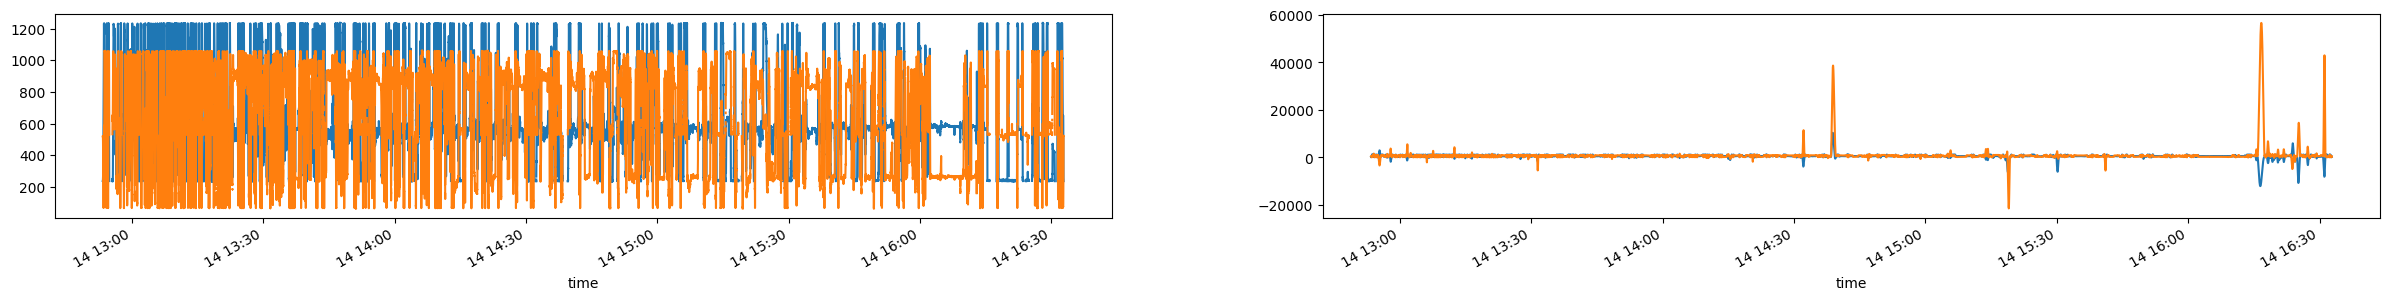

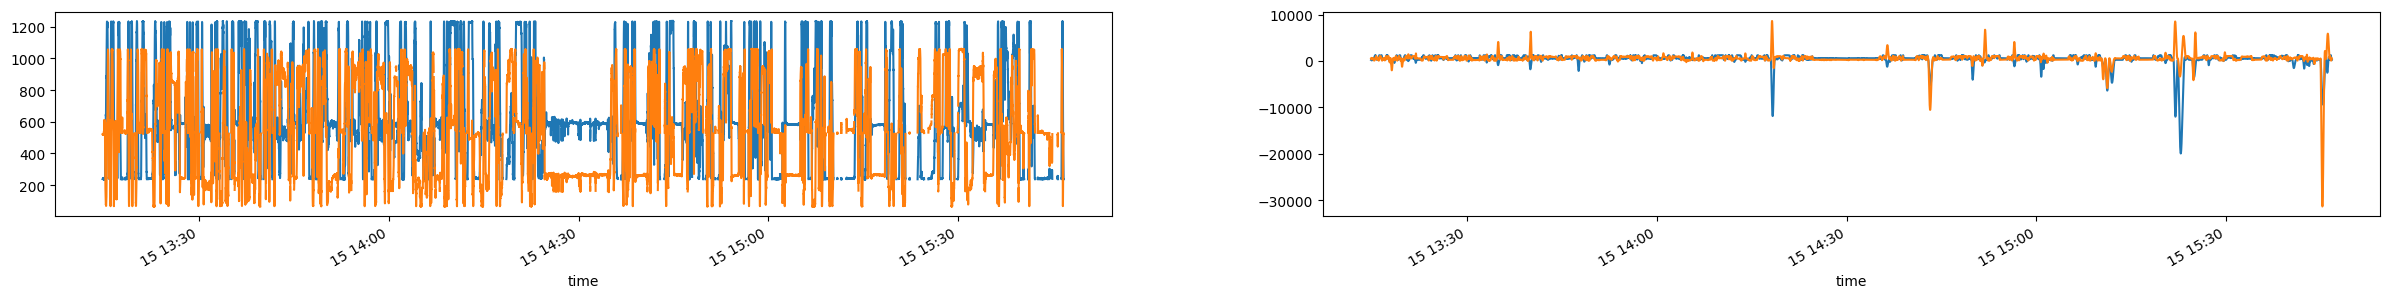

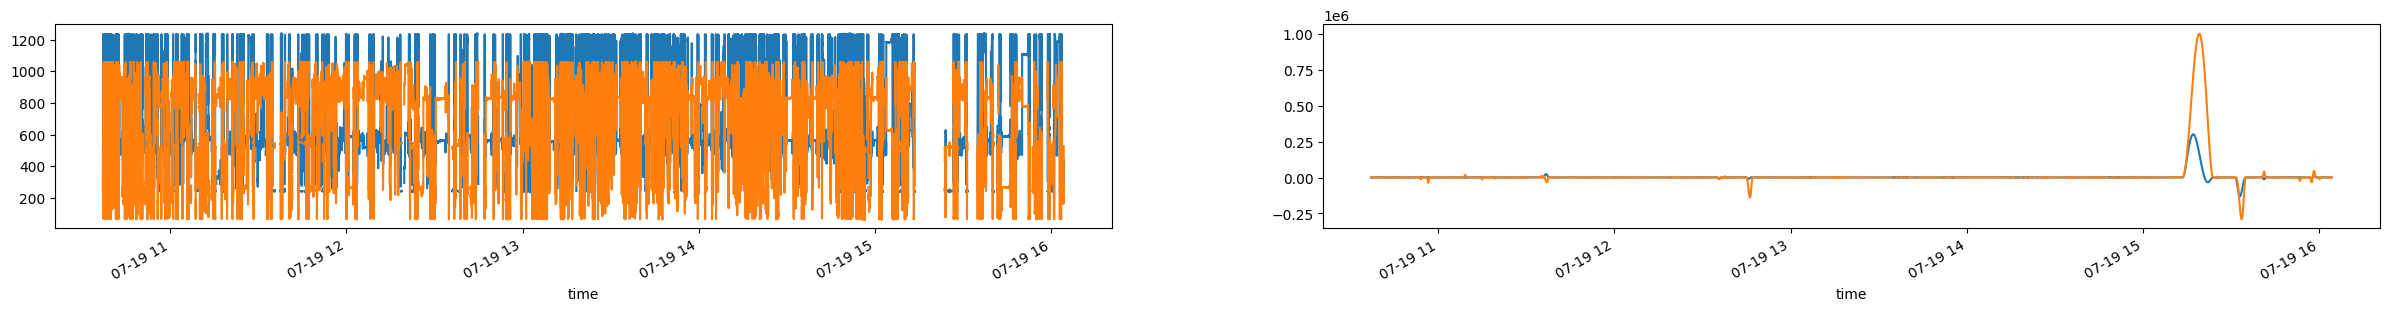

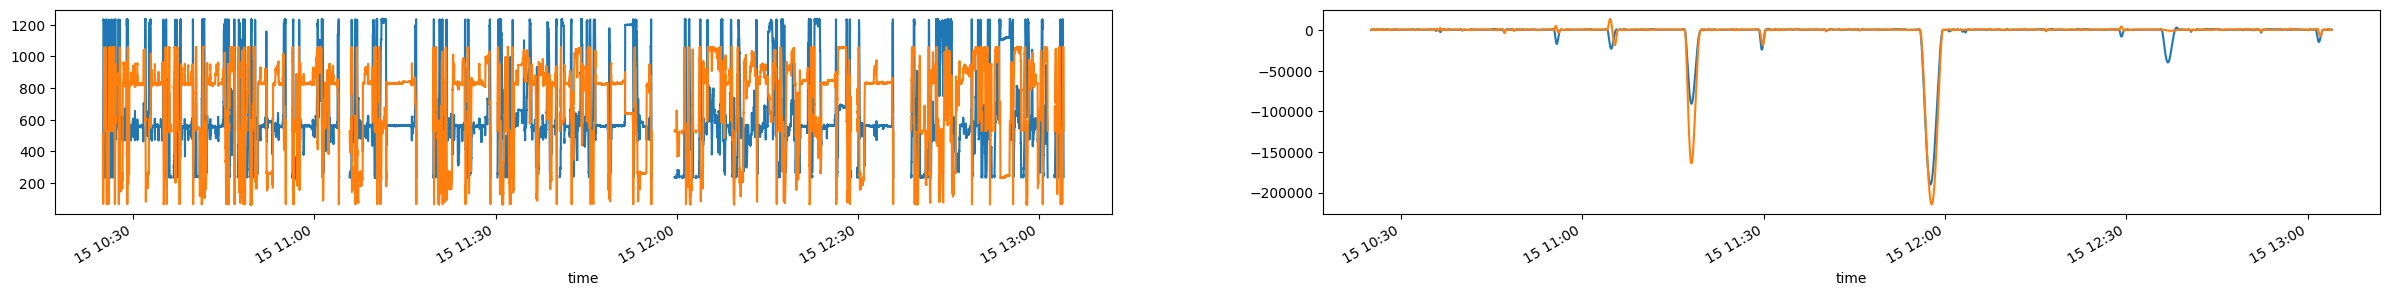

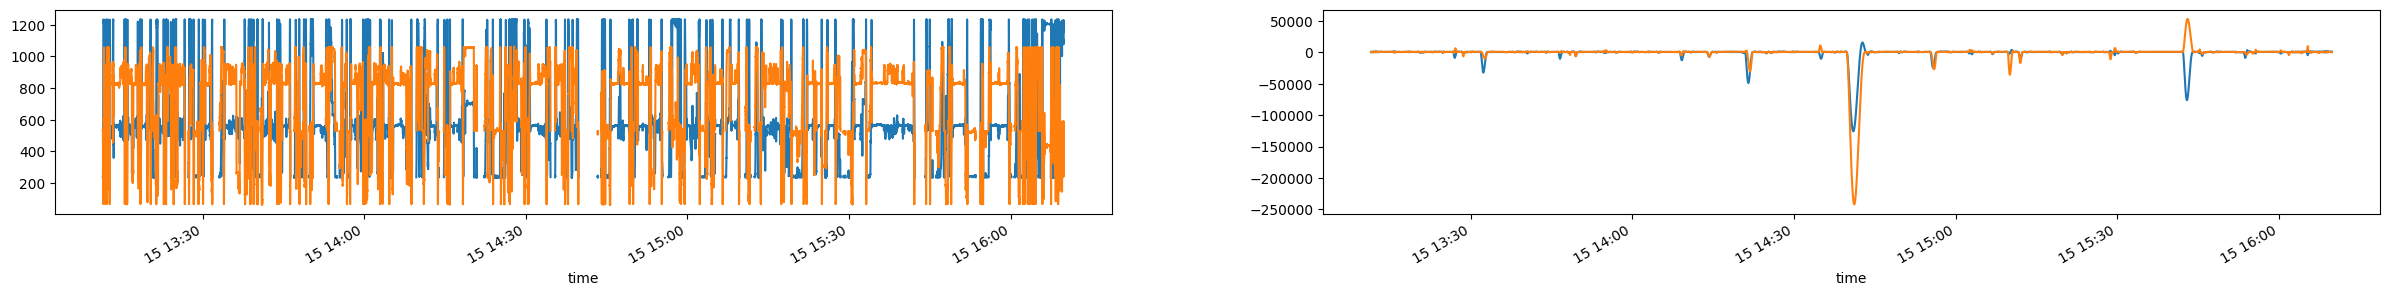

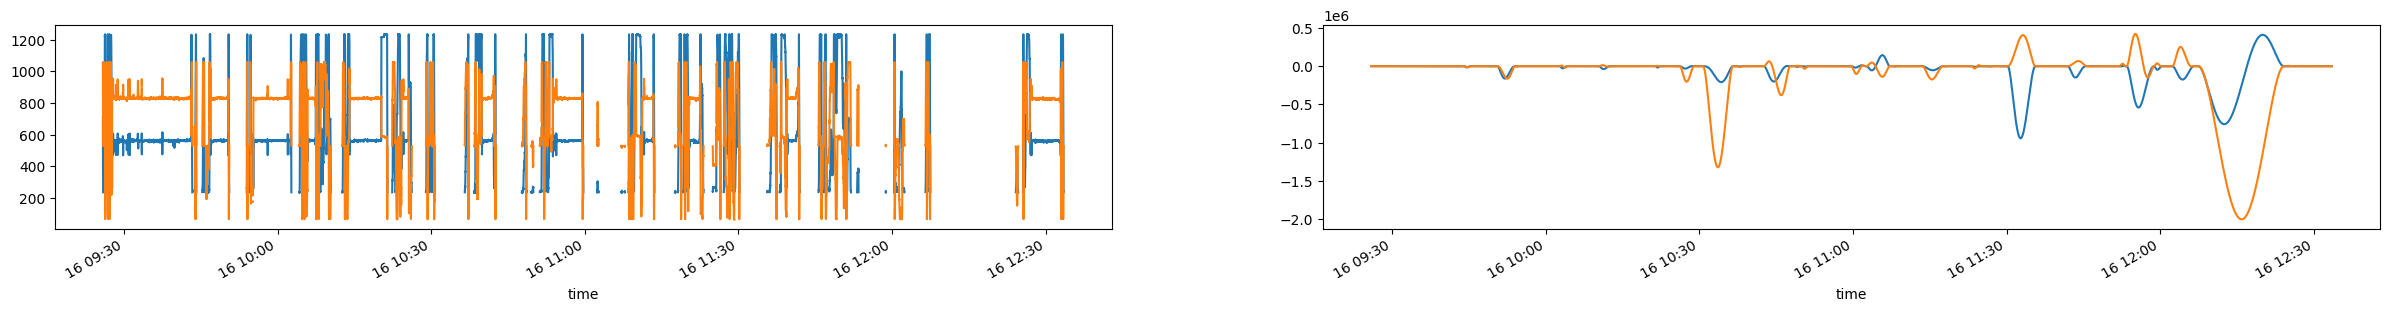

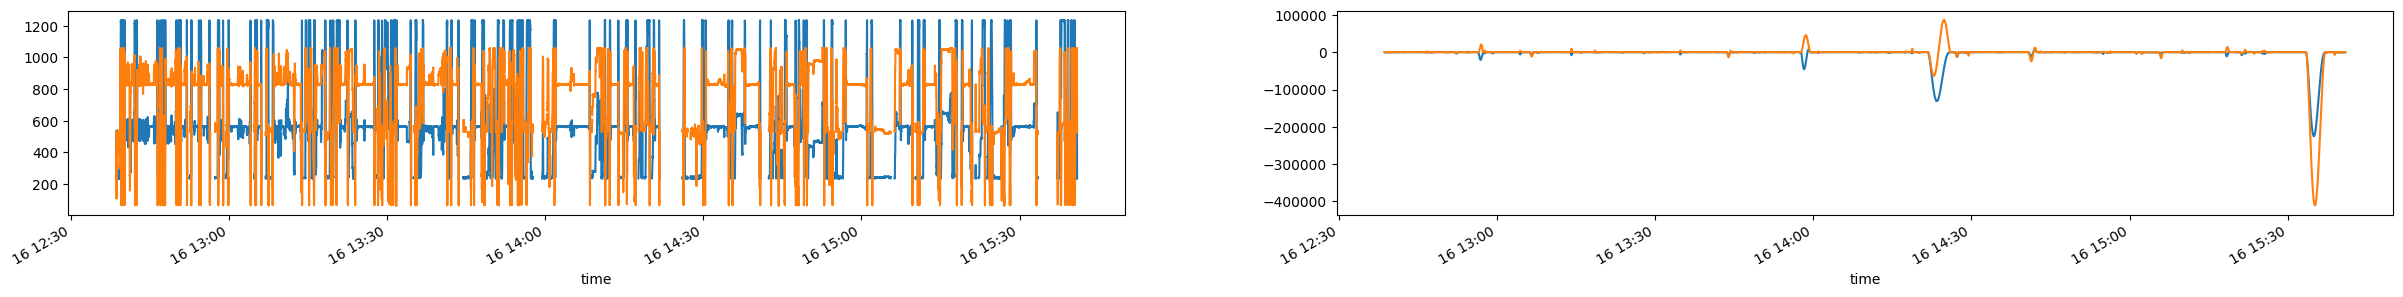

In [19]:
#sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R = LDSParameters_Manual(dt=0.02)
for session, count in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    print(session.id)
    title = 'ShortSession'+str(count)
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
    
    temp_df = mouse_pos.dropna(subset=['x', 'y'])
    first_valid_index = temp_df.index[0]
    last_valid_index = temp_df.index[-1]
    mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]
    
    obs = np.transpose(mouse_pos[["x", "y"]].to_numpy())

    date_times = pd.to_datetime(mouse_pos.index)
    dt = (date_times[1]-date_times[0]).total_seconds()
    
    #sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Q, m0, V0, Z, R = LDSParameters_Learned(obs[:,:10000], dt, sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R)

    filterRes = inference.filterLDS_SS_withMissingValues_np(
        y=obs, B=B, Q=Q, m0=m0, V0=V0, Z=Z, R=R)
    np.savez_compressed(title + 'filterRes.npz', **filterRes)
    
    smoothRes = inference.smoothLDS_SS( 
        B=B, xnn=filterRes["xnn"], Vnn=filterRes["Vnn"],
        xnn1=filterRes["xnn1"], Vnn1=filterRes["Vnn1"], m0=m0, V0=V0)
    np.savez_compressed(title + 'smoothRes.npz', **smoothRes)

    mouse_pos['smoothed_position_x'] = pd.Series(smoothRes['xnN'][0][0], index=mouse_pos.index)
    mouse_pos['smoothed_position_y'] = pd.Series(smoothRes['xnN'][3][0], index=mouse_pos.index)
    fig, axs = plt.subplots(1,2, figsize = (30,3))
    mouse_pos.x.plot(ax = axs[0])
    mouse_pos.y.plot(ax = axs[0])
    mouse_pos.smoothed_position_x.plot(ax = axs[1])
    mouse_pos.smoothed_position_y.plot(ax = axs[1])
    plt.savefig(title+'.png')

## Long Sessions

# Kinematic Data Summary - Short

In [ ]:
def DrawPelletDeliveryIntervals(mouse_pos):
    date_times = pd.to_datetime(mouse_pos.index)
    start, end = mouse_pos.index[0], mouse_pos.index[-1]
    dt = (date_times[1]-date_times[0]).total_seconds()
    
    intervals = pd.date_range(start=start.floor('H'), end=end.ceil('H'), freq='30T')
    if intervals[-1] != end: intervals = intervals.union([end])
    if intervals[0] != start: intervals = pd.to_datetime([start] + list(intervals))

    num_intervals = len(intervals) - 1
    fig, axs = plt.subplots(2, num_intervals, figsize=(7*num_intervals-2, 3), constrained_layout=True)
    
    for i in range(num_intervals):
        start, end = intervals[i], intervals[i+1]
        pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
        pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
        
        for pellet in pellets_patch2.itertuples():
            forage_time = pellet.Index
            axs[0,i].axvline(pd.Timestamp(forage_time), color='green', linewidth=1)
        axs[0,i].set_xticks([]) 
        axs[0,i].set_yticks([]) 
        axs[0,i].set_facecolor('white') 
        axs[0,i].set_ylabel('P2', fontsize = 8)
        axs[0,i].spines['top'].set_visible(False)
        axs[0,i].spines['right'].set_visible(False)
        axs[0,i].set_xlim(start, end)

        for pellet in pellets_patch1.itertuples():
            forage_time = pellet.Index
            axs[1,i].axvline(pd.Timestamp(forage_time), color='brown', linewidth=1)
        axs[1,i].set_yticks([])  
        axs[1,i].set_facecolor('white')  
        axs[1,i].set_ylabel('P1', fontsize = 8)
        axs[1,i].spines['top'].set_visible(False)
        axs[1,i].spines['right'].set_visible(False)
        axs[1,i].set_xlim(start, end)

    plt.show()

In [25]:
def DrawPositionMap(mouse_pos, data_type = 'Position'):
    date_times = pd.to_datetime(mouse_pos.index)
    start, end = mouse_pos.index[0], mouse_pos.index[-1]
    dt = (date_times[1]-date_times[0]).total_seconds()
    
    intervals = pd.date_range(start=start.floor('H'), end=end.ceil('H'), freq='30T')
    if intervals[-1] != end: intervals = intervals.union([end])
    if intervals[0] != start: intervals = pd.to_datetime([start] + list(intervals))

    num_intervals = len(intervals) - 1
    fig, axs = plt.subplots(1, num_intervals, figsize=(7*num_intervals-2, 5), constrained_layout=True)

    for i in range(num_intervals):
        start, end = intervals[i], intervals[i+1]
        interval_data = mouse_pos[(mouse_pos.index >= start) & (mouse_pos.index < end)]
        
        heatmap, xedges, yedges = np.histogram2d(interval_data['smoothed_position_x'], interval_data['smoothed_position_y'], bins=50)

        ax = axs[i] if num_intervals > 1 else axs
        cax = ax.imshow(heatmap.T, origin='lower', cmap='binary', interpolation='nearest', aspect='auto')
        ax.set_title(f'{start.time()} - {end.time()}')
        ax.set_xlabel('X '+data_type)
        ax.set_ylabel('Y '+data_type)

    plt.show()

In [30]:
def DrawVelocityHistogram(mouse_pos, data_type):
    date_times = pd.to_datetime(mouse_pos.index)
    start, end = mouse_pos.index[0], mouse_pos.index[-1]
    dt = (date_times[1]-date_times[0]).total_seconds()
    
    x_vel, y_vel = mouse_pos['smoothed_velocity_x'], mouse_pos['smoothed_velocity_y']
    vel = np.sqrt(x_vel**2 + y_vel**2)
    mouse_pos['smoothed_velocity'] = pd.Series(vel)
    
    intervals = pd.date_range(start=start.floor('H'), end=end.ceil('H'), freq='30T')
    if intervals[-1] != end: intervals = intervals.union([end])
    if intervals[0] != start: intervals = pd.to_datetime([start] + list(intervals))

    num_intervals = len(intervals) - 1
    fig, axs = plt.subplots(1, num_intervals, figsize=(7*num_intervals-2, 5), constrained_layout=True)

    for i in range(num_intervals):
        start, end = intervals[i], intervals[i+1]
        interval_data = mouse_pos[(mouse_pos.index >= start) & (mouse_pos.index < end)]['smoothed_velocity']

        ax = axs[i] if num_intervals > 1 else axs
        ax.hist(interval_data, bins=50, color='black', alpha=0.7)
        ax.set_title(f'{start.time()} - {end.time()}')
        ax.set_xlabel(data_type)
        ax.set_ylabel('Frequency')

    plt.show()

## Position

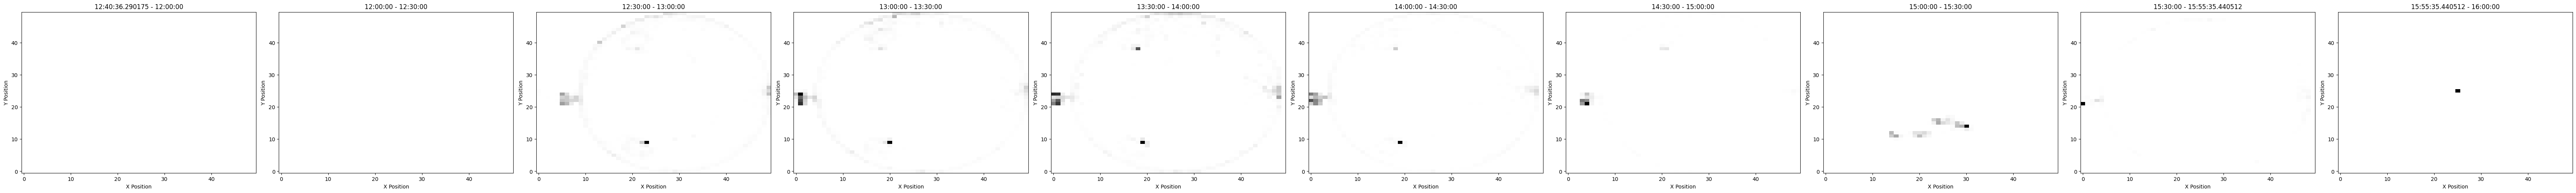

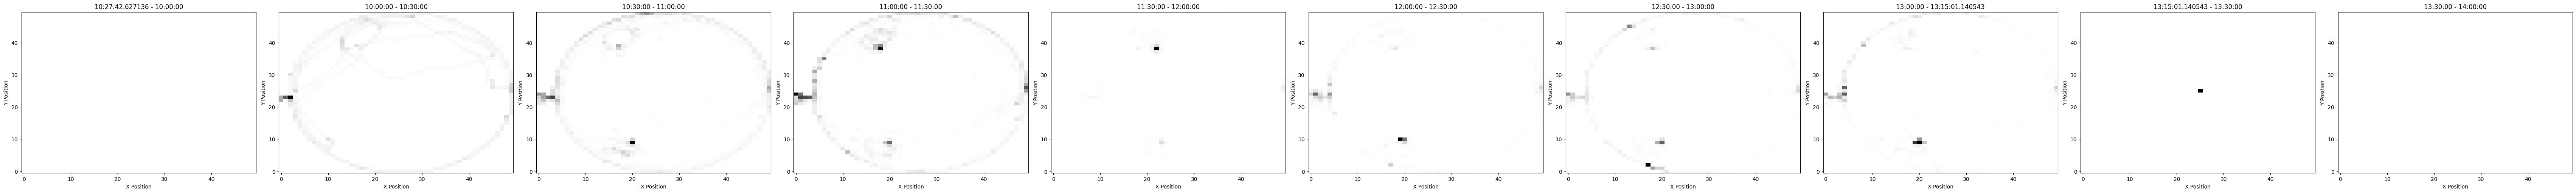

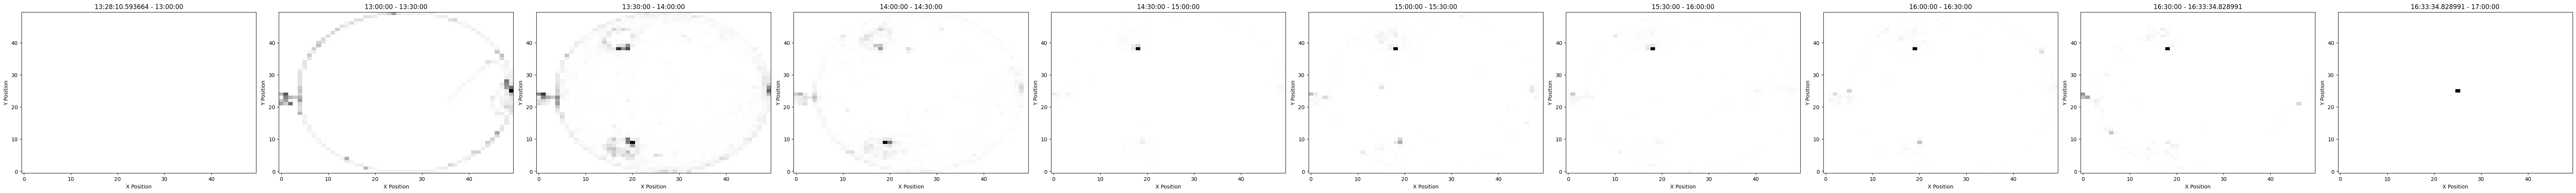

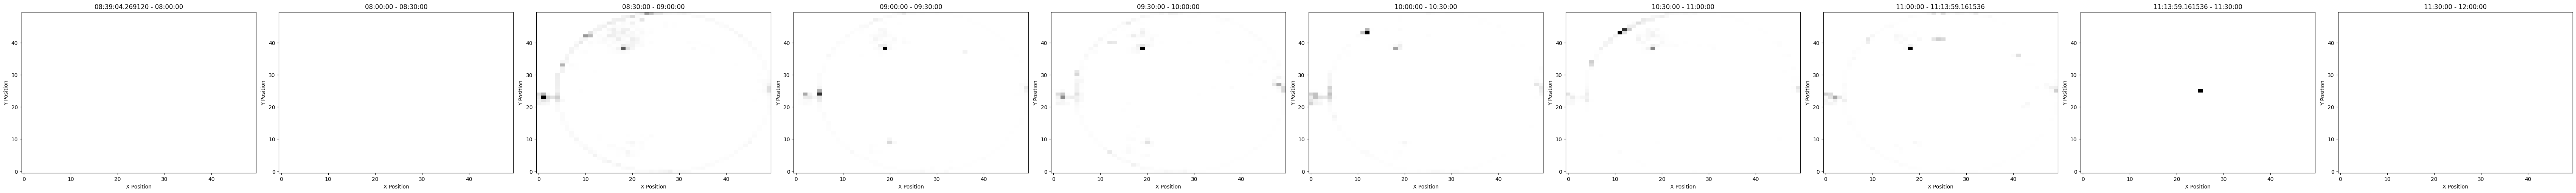

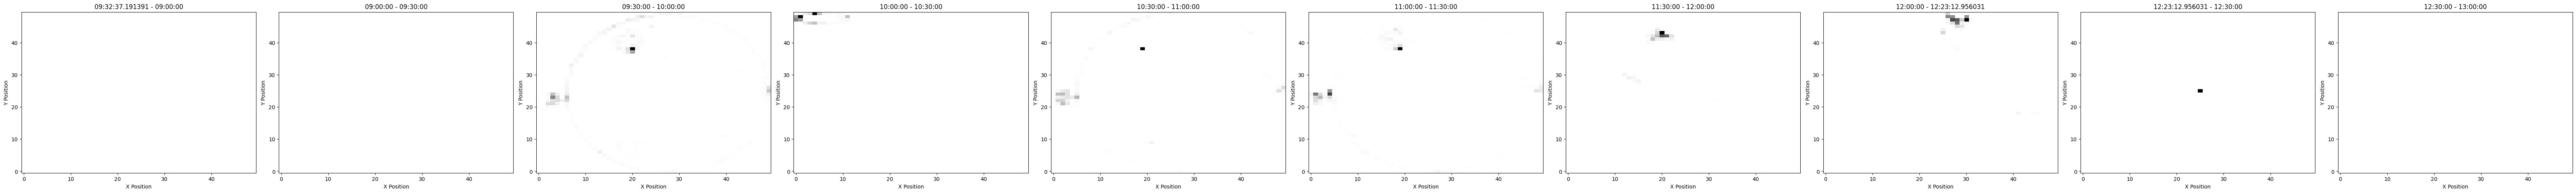

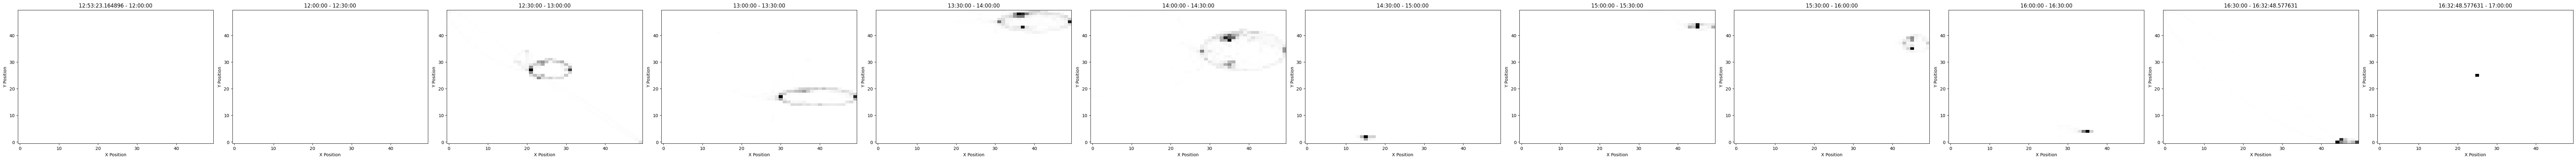

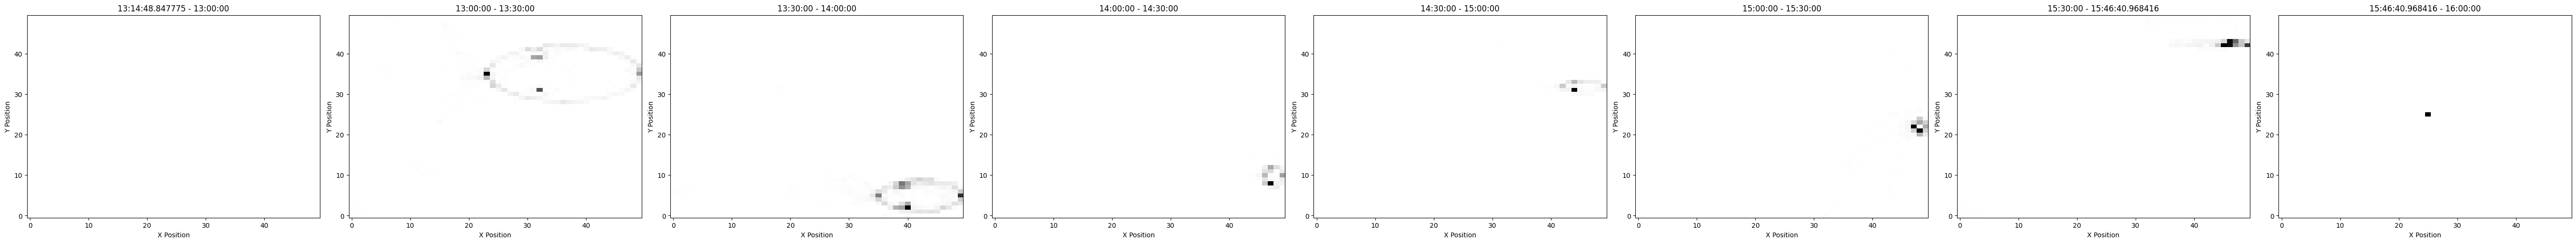

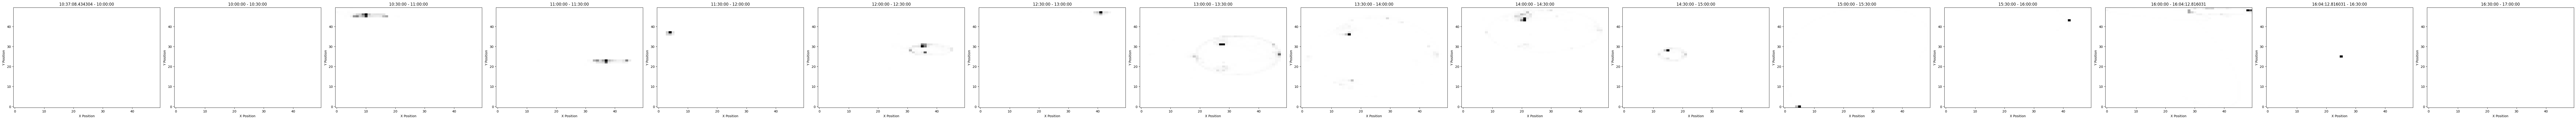

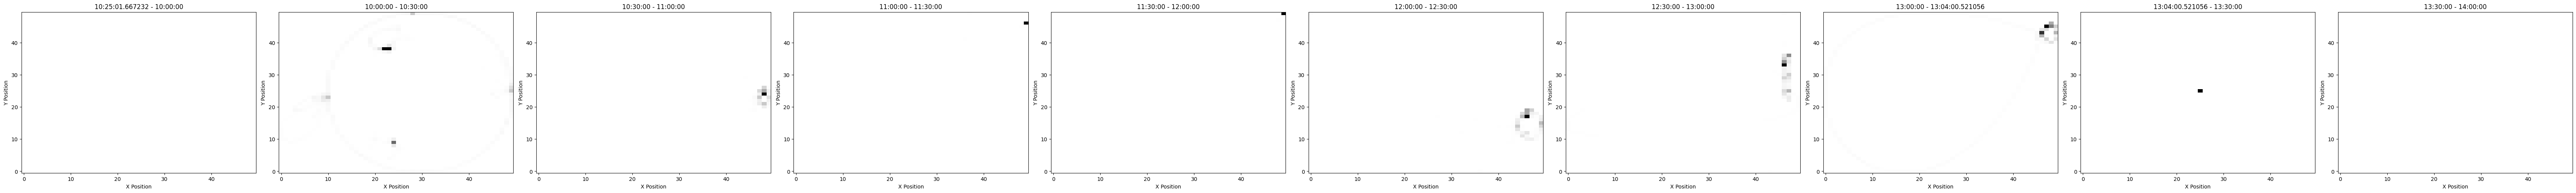

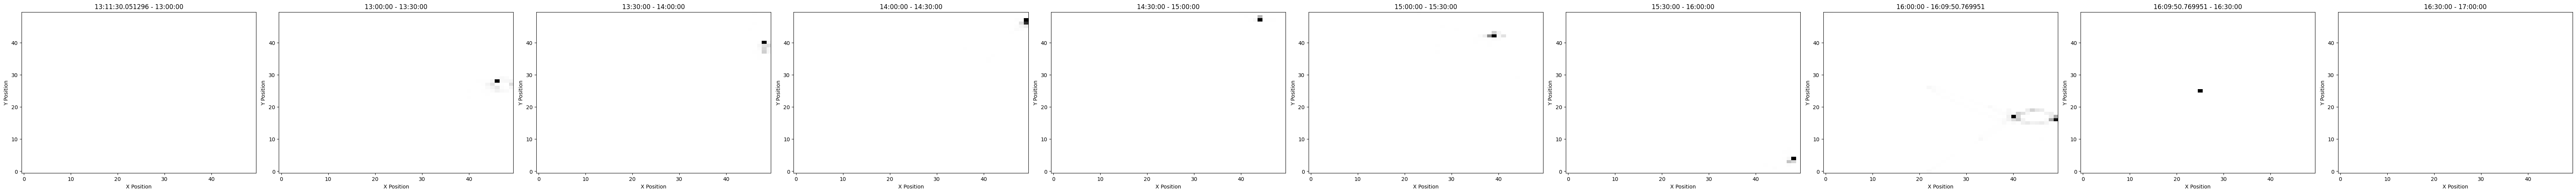

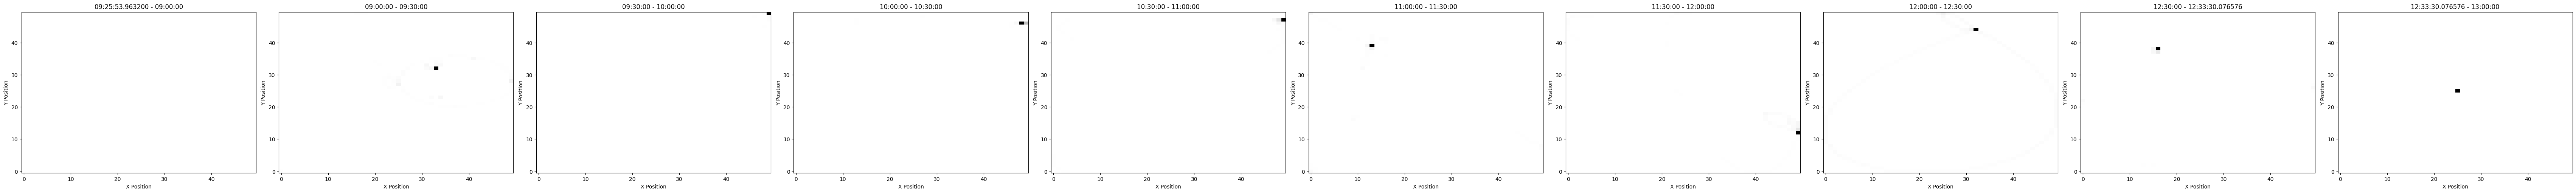

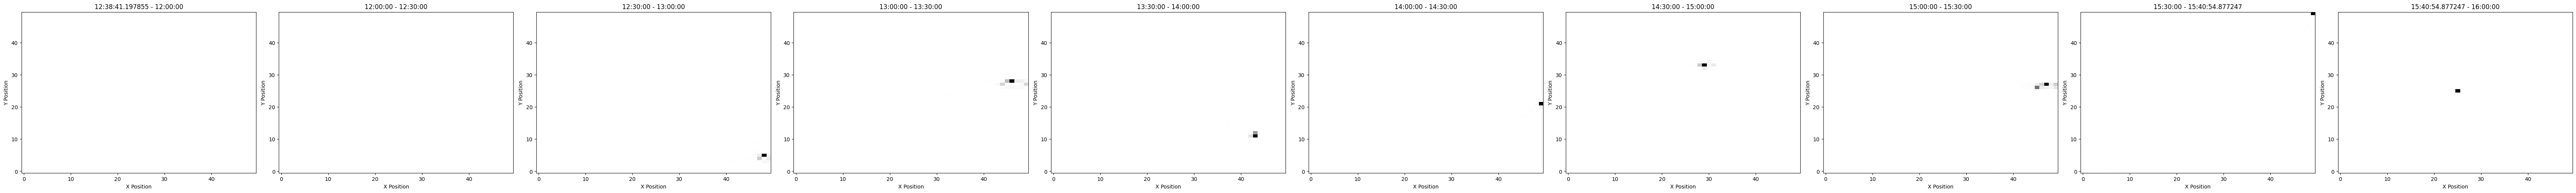

In [26]:
for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(i)
    print(title)
    
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
    
    temp_df = mouse_pos.dropna(subset=['x', 'y'])
    first_valid_index = temp_df.index[0]
    last_valid_index = temp_df.index[-1]
    mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]
    
    filterRes, smoothRes = np.load(title+'filterRes.npz'), np.load(title+'smoothRes.npz')
    mouse_pos['smoothed_position_x'] = pd.Series(smoothRes['xnN'][0][0], index=mouse_pos.index)
    mouse_pos['smoothed_position_y'] = pd.Series(smoothRes['xnN'][3][0], index=mouse_pos.index)
    DrawPositionMap(mouse_pos, data_type='Position')

## Velocity

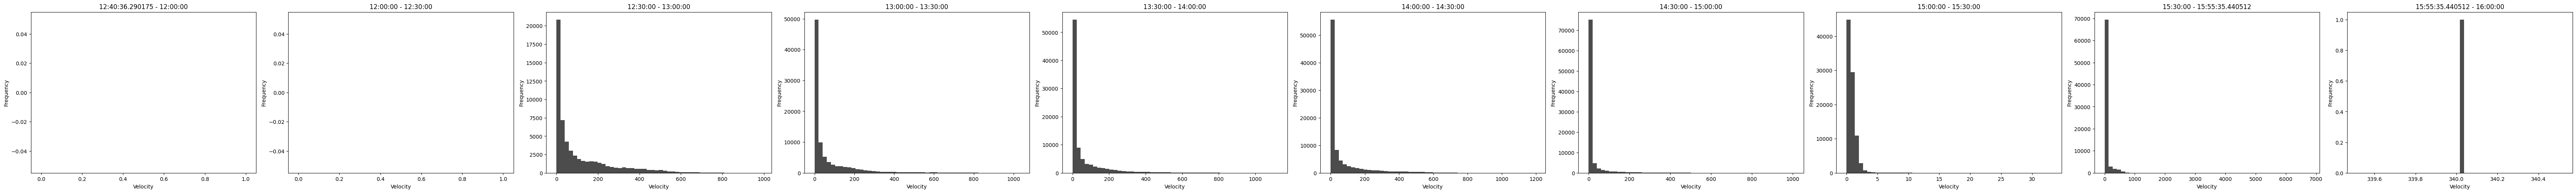

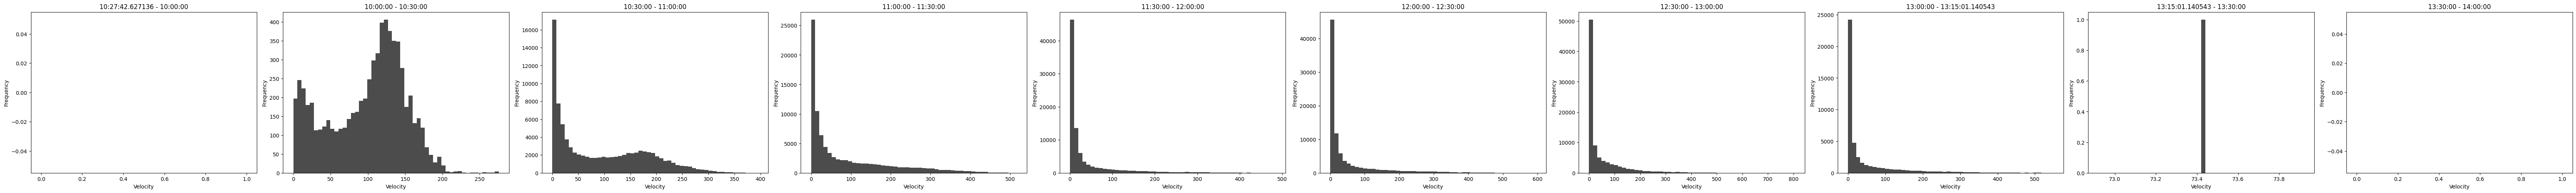

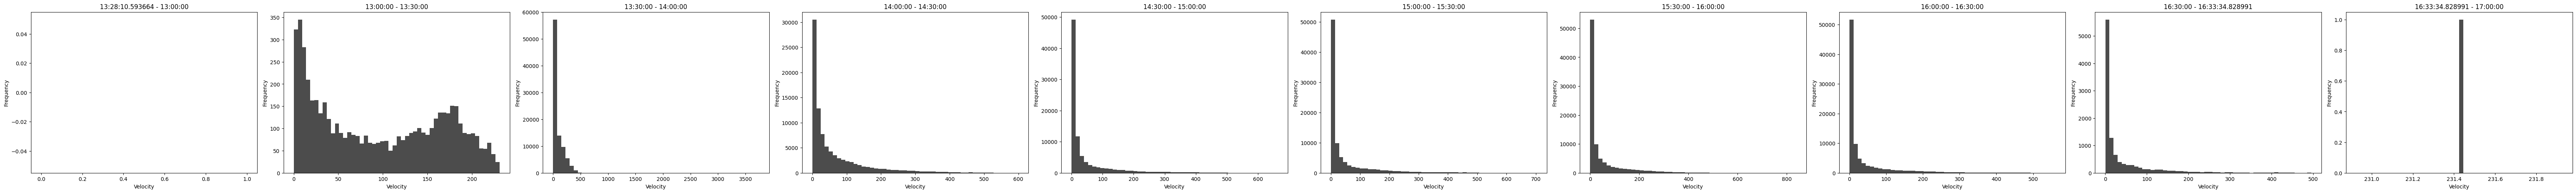

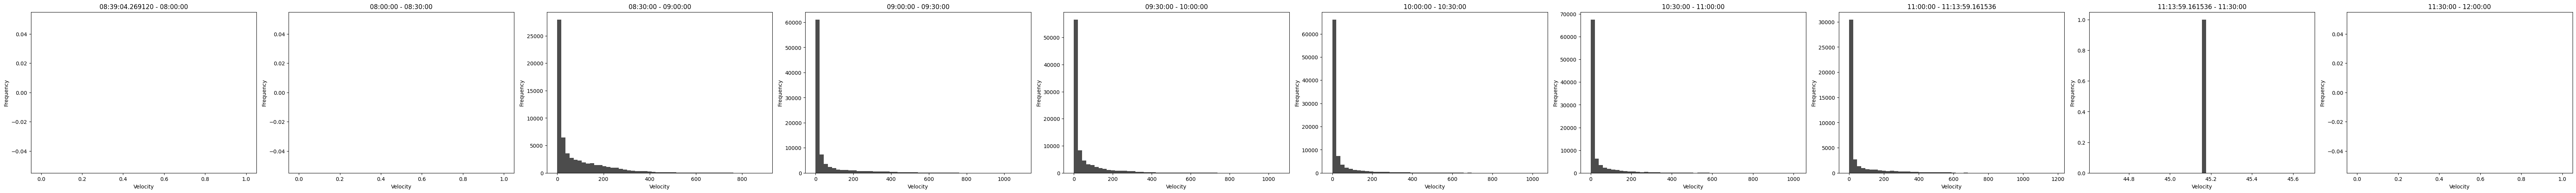

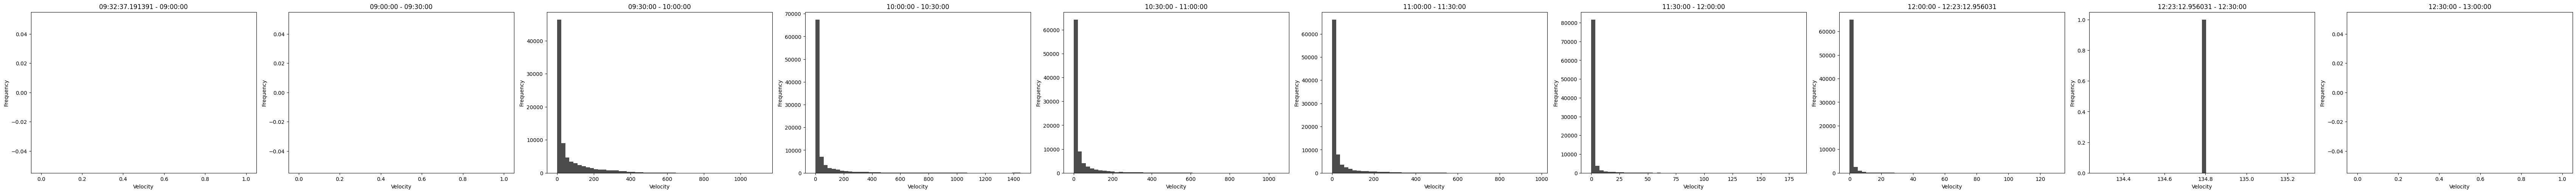

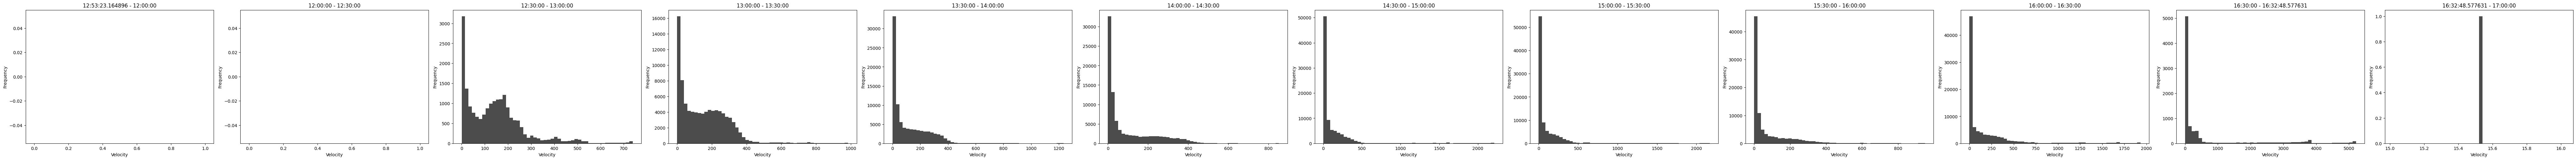

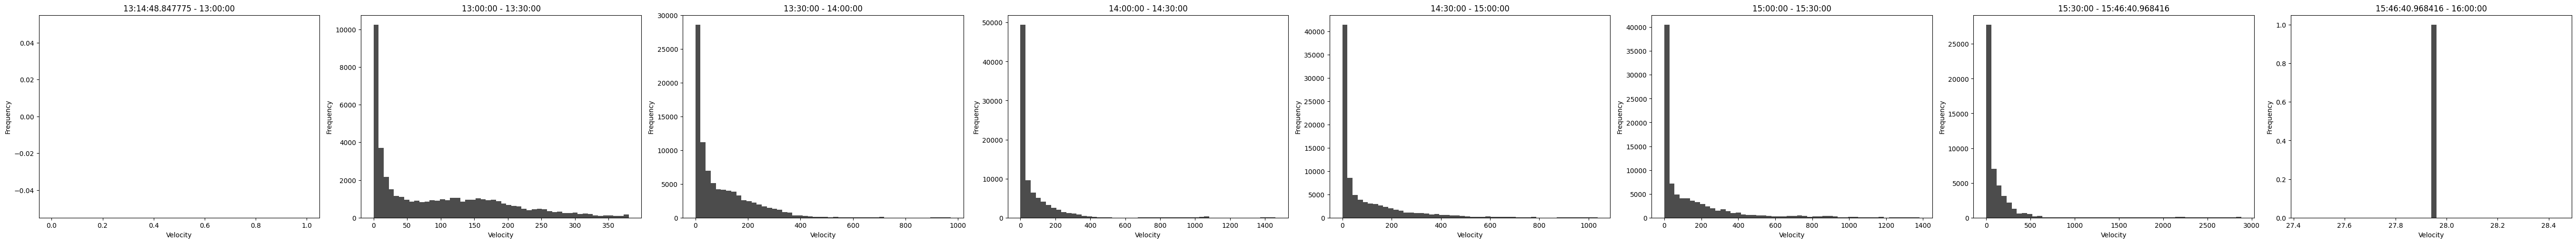

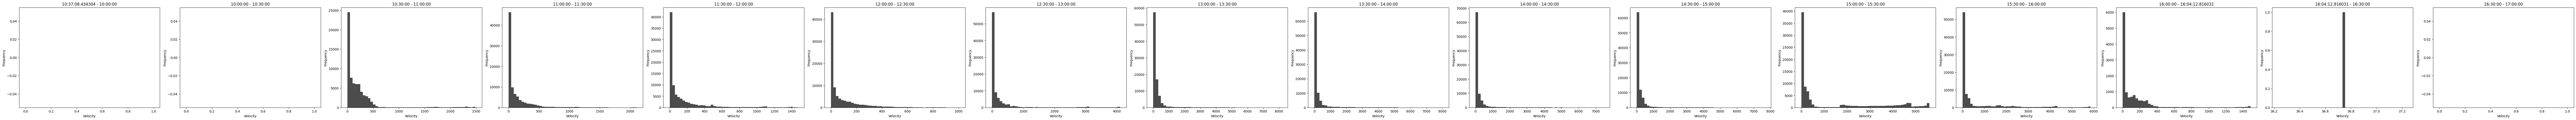

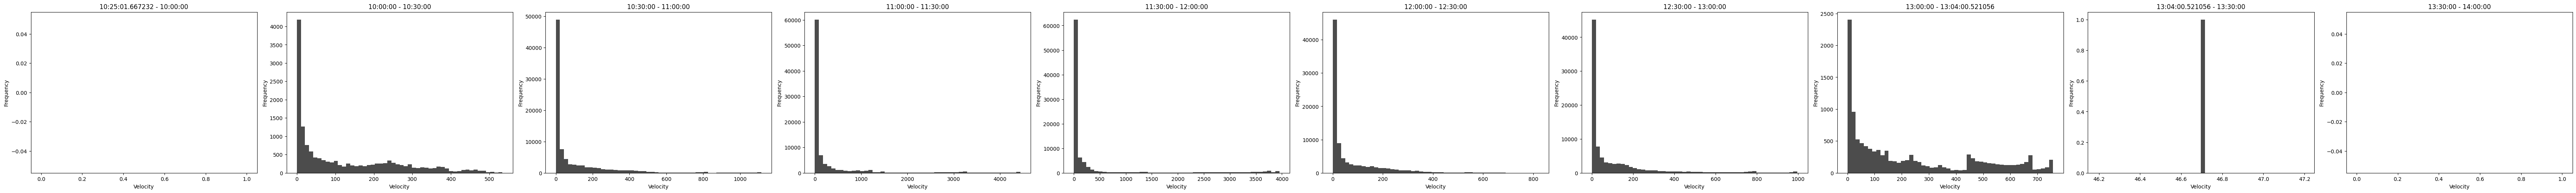

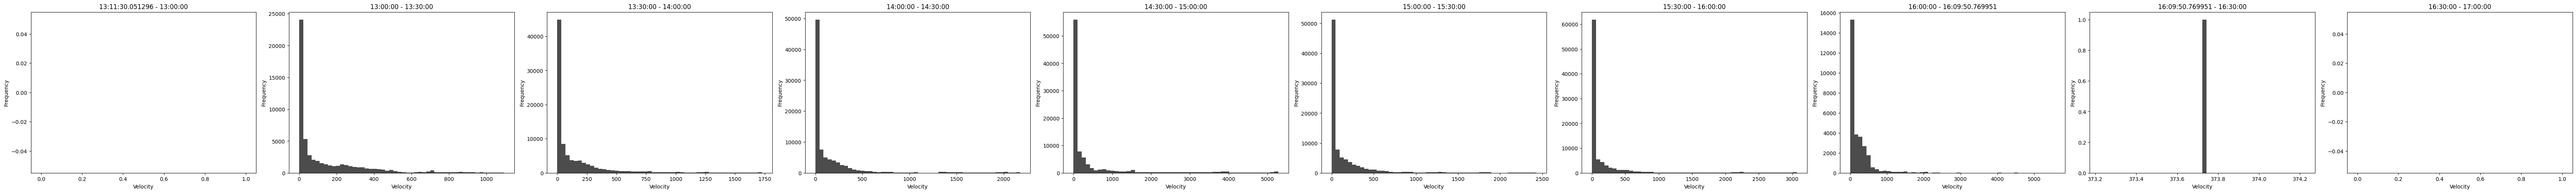

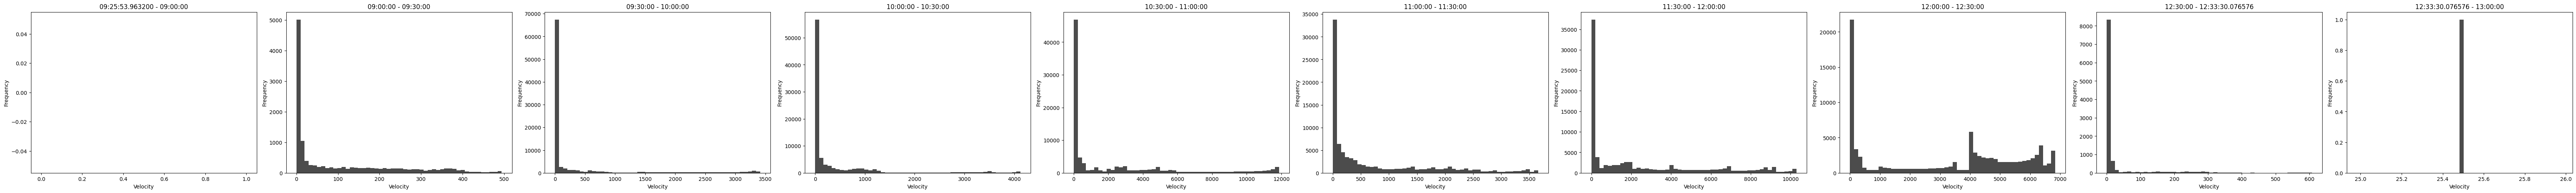

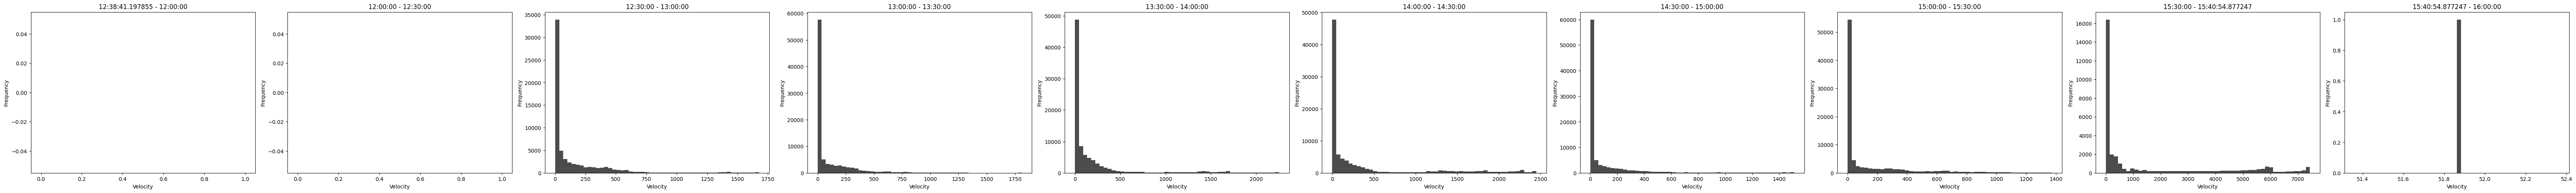

In [29]:
for session, i  in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(i)
    print(title)
    
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
    
    temp_df = mouse_pos.dropna(subset=['x', 'y'])
    first_valid_index = temp_df.index[0]
    last_valid_index = temp_df.index[-1]
    mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]
    
    filterRes, smoothRes = np.load(title+'filterRes.npz'), np.load(title+'smoothRes.npz')
    mouse_pos['smoothed_velocity_x'] = pd.Series(smoothRes['xnN'][1][0], index=mouse_pos.index)
    mouse_pos['smoothed_velocity_y'] = pd.Series(smoothRes['xnN'][4][0], index=mouse_pos.index)
    DrawVelocityHistogram(mouse_pos, 'Velocity')

## Acceleration Histogram

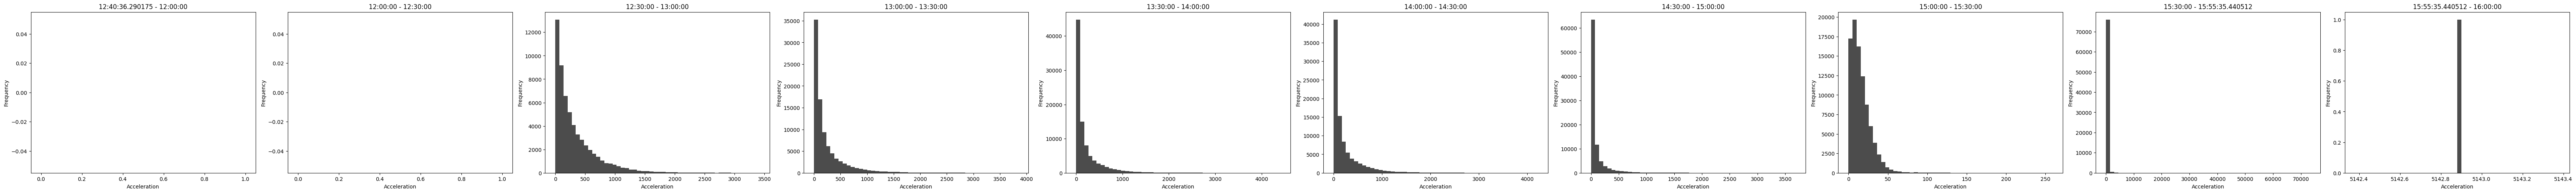

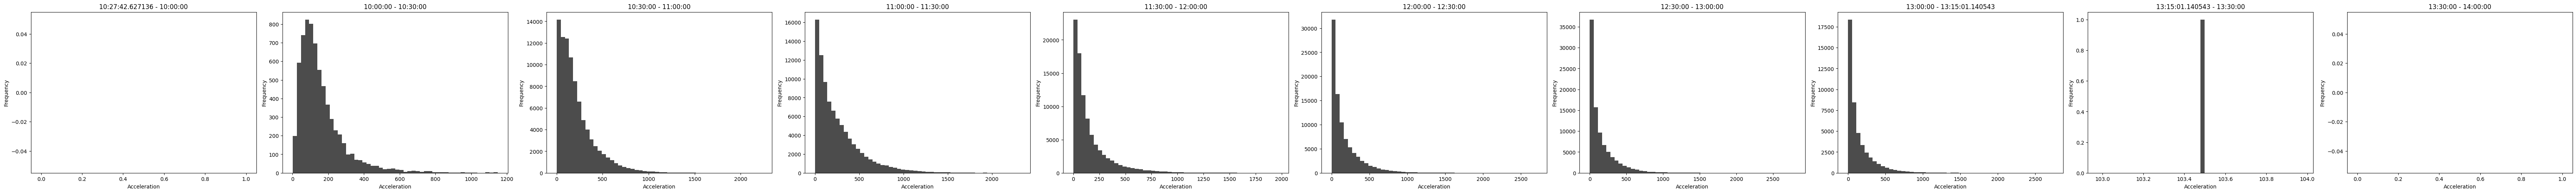

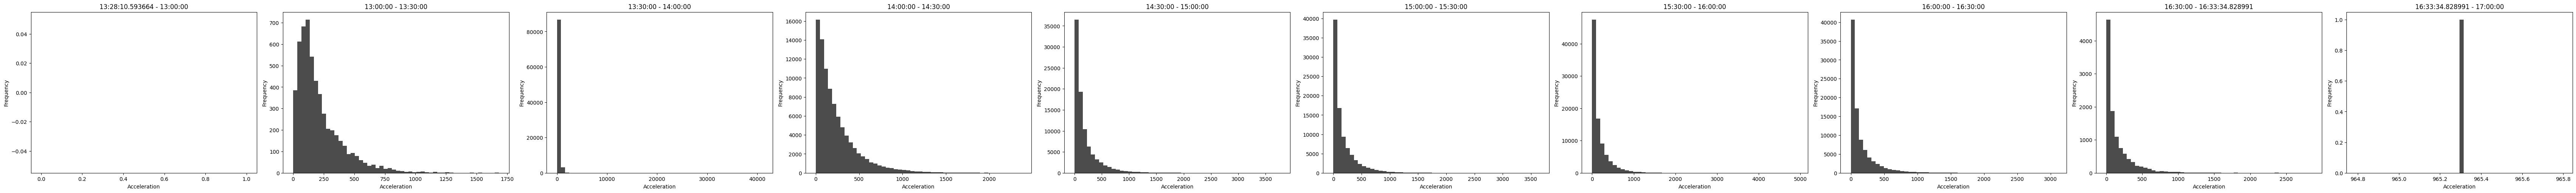

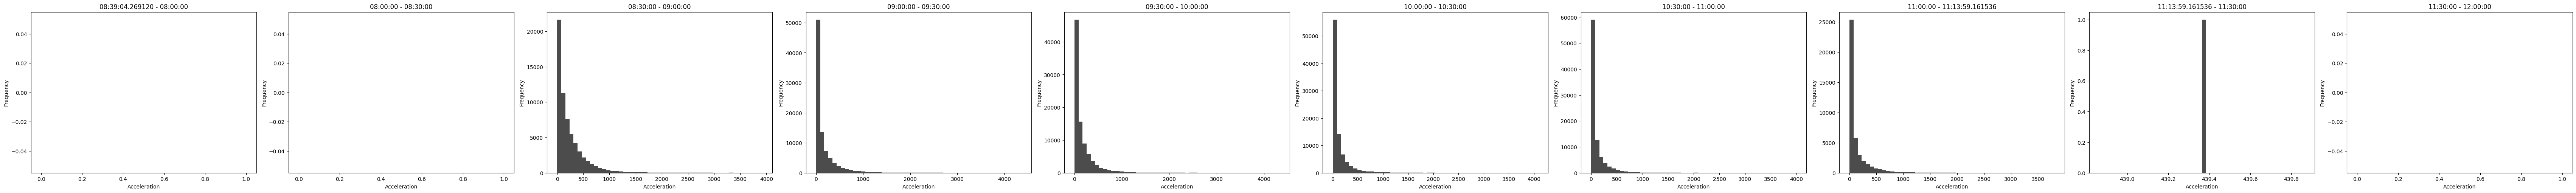

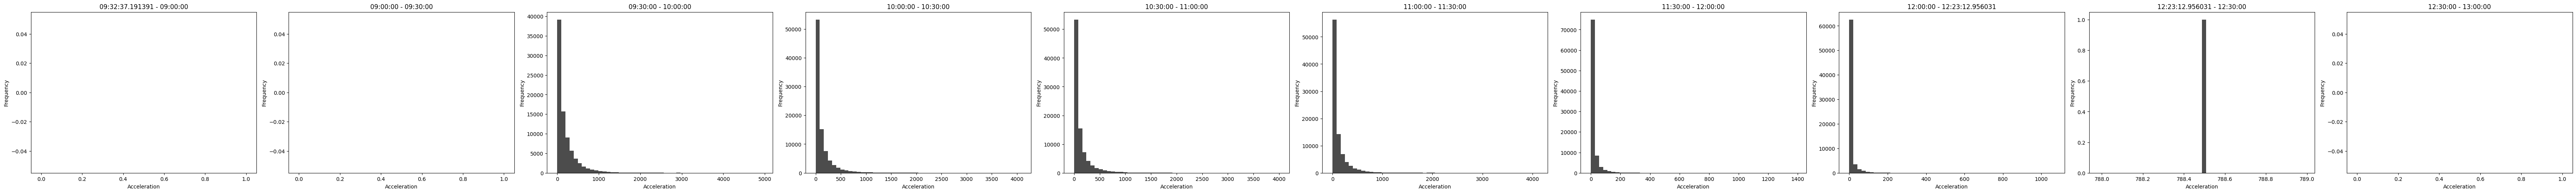

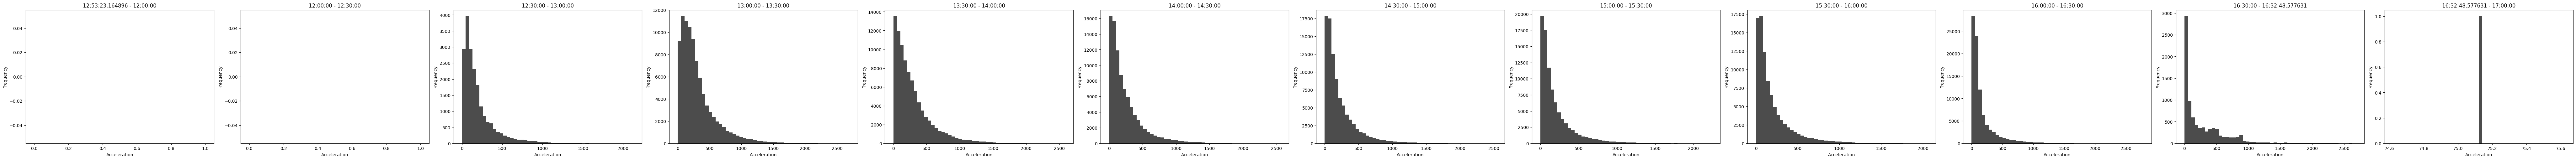

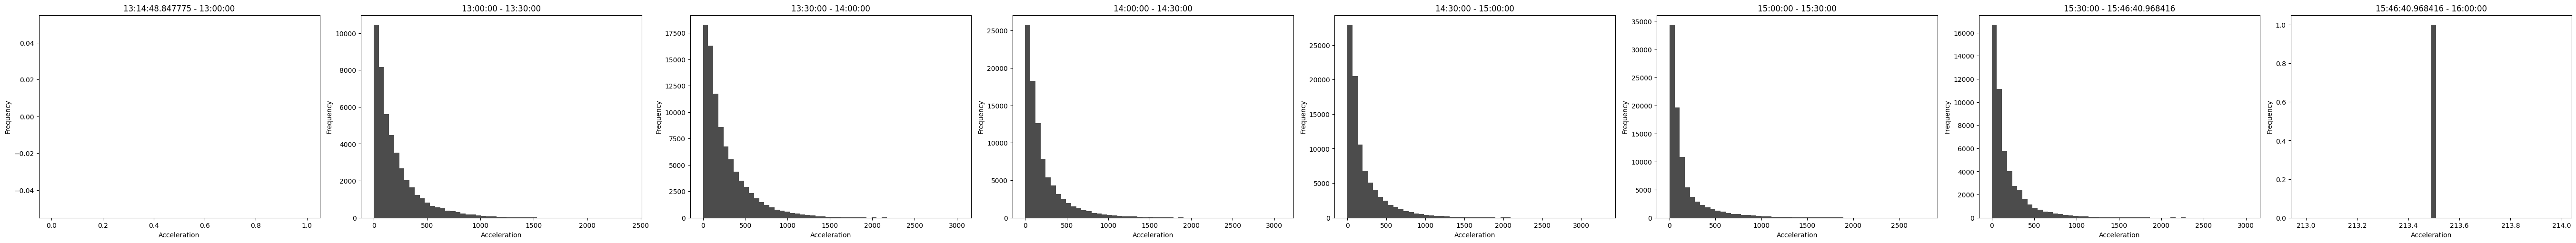

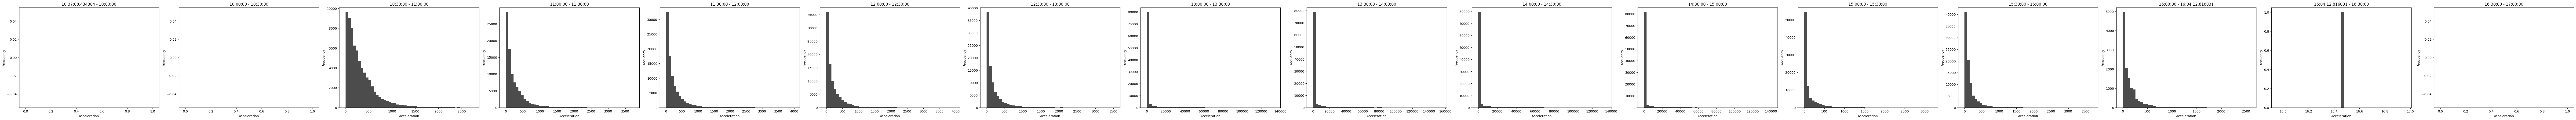

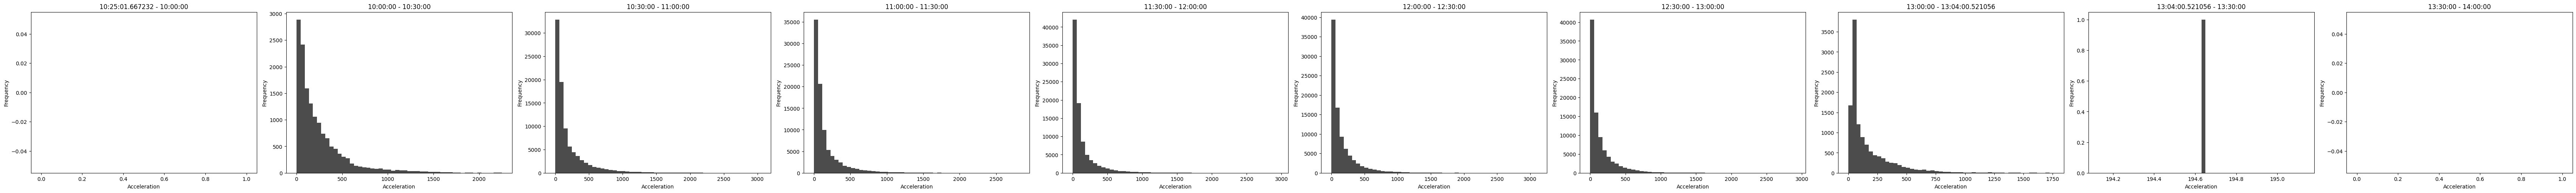

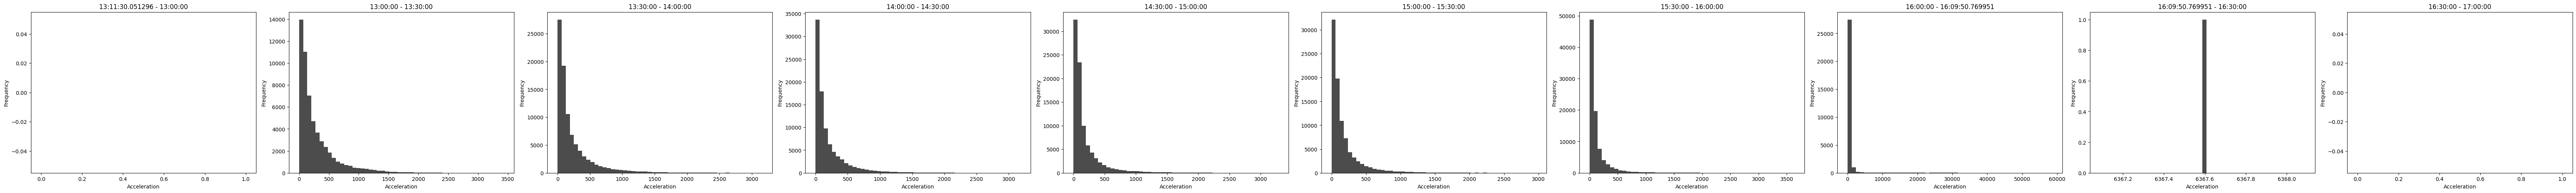

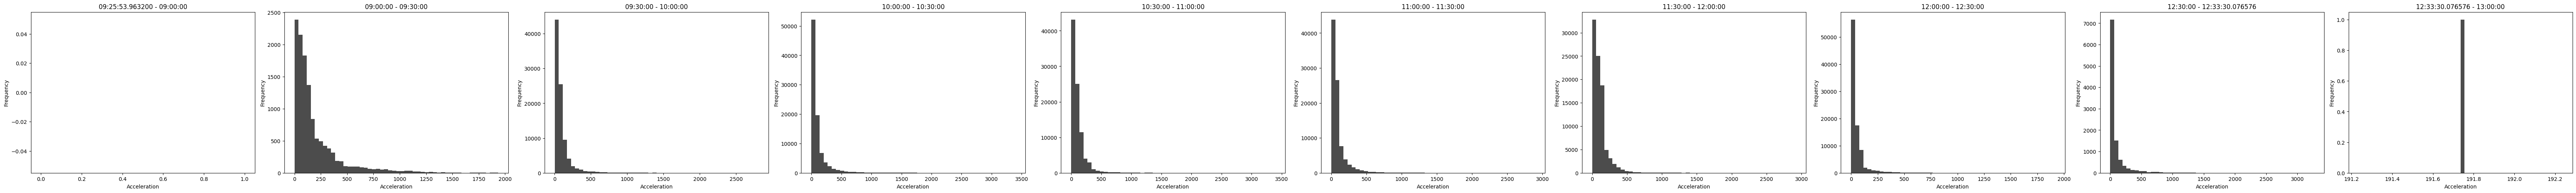

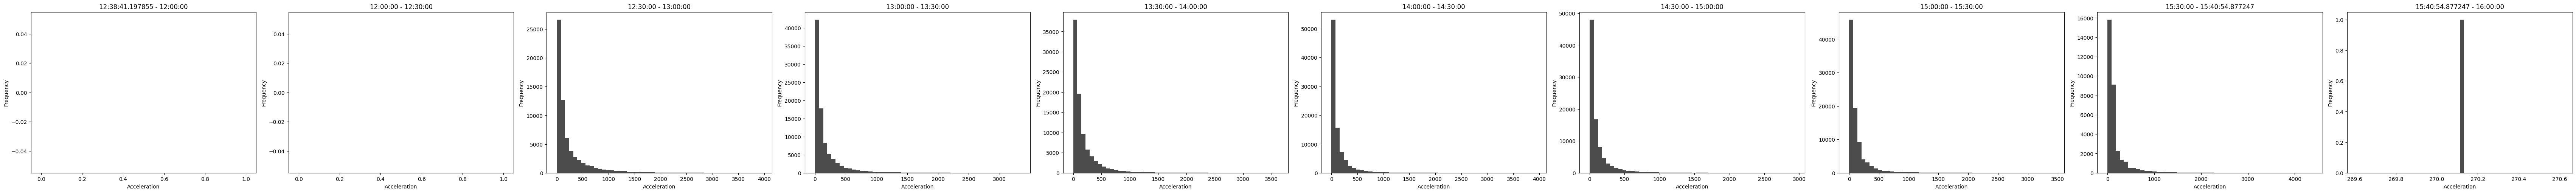

In [31]:
for session, i  in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(i)
    print(title)
    
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
    
    temp_df = mouse_pos.dropna(subset=['x', 'y'])
    first_valid_index = temp_df.index[0]
    last_valid_index = temp_df.index[-1]
    mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]
    
    filterRes, smoothRes = np.load(title+'filterRes.npz'), np.load(title+'smoothRes.npz')
    mouse_pos['smoothed_velocity_x'] = pd.Series(smoothRes['xnN'][2][0], index=mouse_pos.index)
    mouse_pos['smoothed_velocity_y'] = pd.Series(smoothRes['xnN'][5][0], index=mouse_pos.index)
    DrawVelocityHistogram(mouse_pos, 'Acceleration')